<a href="https://colab.research.google.com/github/arahlin/spt3g_tutorials/blob/main/filter_and_bin_mapmaking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timestream Processing and Mapmaking with SPT Data

In this notebook, we'll be looking at some data from the South Pole Telescope using the [spt3g_software](https://github.com/CMB-S4/spt3g_software) code.  The data processing we will cover in this tutorial is typically one of the first stages in CMB data analysis: cleaning up the timestreams and filtering out unwanted noise and features, and binning the timestreams into map pixels.  While the tools we'll be using are part of the SPT software suite, the techniques are typical of any such time-domain dataset.

To get started, let's first download and install all of the necessary components.  If you're running this notebook from one of the SPT analysis machines, you should already have `spt3g_software` installed.  If you're running it on your laptop or in Google Colab, the code below will install the public package for you.

For SPT collaboration members:  we use the *private* version of the software, which includes extra libraries.  The github repo for the private code can be found [here](https://github.com/SouthPoleTelescope/spt3g_software) and links to [this documentation](https://southpoletelescope.github.io/spt3g_software/).

In [ ]:
from distutils import core
# install required packages
!ls /sptlocal || (python -c "import spt3g" || python -m pip install spt3g)

# SPT users: link to dataset
!ls spt3g_tutorial_data || ( \
    ls /sptlocal/user/arahlin/spt3g_tutorial_data && \
    ln -s /sptlocal/user/arahlin/spt3g_tutorial_data \
)

# Public users: download dataset
!ls spt3g_tutorial_data || ( \
    rm -f spt3g_tutorial_data.tar.gz && \
    wget https://sptlocal.grid.uchicago.edu/~arahlin/cmb_school_2024/spt3g_tutorial_data.tar.gz && \
    tar xzvf spt3g_tutorial_data.tar.gz \
)

# delete cruft
!rm -rf sample_data

While the above cell is executing (the download may take some time if you're doing this on a local machine), spend a few minutes familiarizing yourself with the [documentation](https://cmb-s4.github.io/spt3g_software/) (or [for SPT members](https://southpoletelescope.github.io/spt3g_software/)).  Today, we'll be covering the following topics:

- how to work with G3Frames and G3FrameObjects, and combining them into pipelines
- how to use G3Units
- how to work with detector calibration data
- the basics of timestream processing and working with G3TimestreamMap objects
- simple (filter-and-bin) mapmaking, which combines detector timestreams into a map on the sky

Once the installation is complete, let's make sure the package works, and import all the necessary libraries into the python environment:

In [2]:
import spt3g
from spt3g import core
from spt3g.core import G3Units as U
import numpy as np
import matplotlib.pyplot as plt

## G3 Data Format

The G3 file format stores data into "frames", which behave much like python `dict`s, with a few additional features.  Let's start by reading in a set of static calibration data for a subset of SPT detectors.  One way to load a file from disk is to use the `G3File` class.  When initialized with a filename, this object behaves like a generator, which returns a frame when looped over.  In general, you do *not* want to read every frame in a file like this using `list`; this risk loading every single frame in a large file into memory at the same time.  Later in this tutorial, you'll see how to iterate over many frames using a concept called *pipelines*.  For now, we happen to know that this particular file contains only a single frame, so we can convert the generator into a list and return the first frame:

In [3]:
calframe = list(core.G3File("spt3g_tutorial_data/calibration.g3"))[0]
print(calframe)

Frame (Observation) [
"observation_detector_sets" (spt3g._libcore.G3VectorVectorString) => 54 elements
"observation_name" (spt3g._libcore.G3String) => "test_patch-0-0"
"observation_uid" (spt3g._libcore.G3Int) => 1180409039
"scan_el" (spt3g._libcore.G3Double) => 0.541925
"scan_el_astropy_units" (spt3g._libcore.G3String) => "deg"
"scan_el_units" (spt3g._libcore.G3Int) => 6
"scan_max_az" (spt3g._libcore.G3Double) => 2.25603
"scan_max_az_astropy_units" (spt3g._libcore.G3String) => "rad"
"scan_max_az_units" (spt3g._libcore.G3Int) => 6
"scan_max_el" (spt3g._libcore.G3Double) => 0.541925
"scan_max_el_astropy_units" (spt3g._libcore.G3String) => "rad"
"scan_max_el_units" (spt3g._libcore.G3Int) => 6
"scan_min_az" (spt3g._libcore.G3Double) => 2.15057
"scan_min_az_astropy_units" (spt3g._libcore.G3String) => "rad"
"scan_min_az_units" (spt3g._libcore.G3Int) => 6
"scan_min_el" (spt3g._libcore.G3Double) => 0.541925
"scan_min_el_astropy_units" (spt3g._libcore.G3String) => "rad"
"scan_min_el_units" (spt

This frame contains several keys.  Let's take a look at the `DetectorCalibration` object first.  This is a mapping (i.e. a `dict`), keyed by detector name, of calibration constants for each detector in the dataset.

In [38]:
cal = calframe["DetectorCalibration"]
print(cal)
# print the first 10 keys
print(cal.keys()[:10])
# print the calibration for one detector
print(cal["2019.00e"])

3276 elements
['2019.00e', '2019.00k', '2019.00n', '2019.00r', '2019.00t', '2019.012', '2019.014', '2019.01f', '2019.01k', '2019.01q']
-0.6491192244684366


All frames have a `.type` attribute which tells the user something about what kind of data to expect them to contain.  The above frame is a `Calibration` frame, which typically contains the sorts of data one might use to *calibrate* some other data.  Other common frame types are `Scan` frames, which typically contain some time-ordered data, and `Map` frames, which typically contain sky maps.  There is no specific standard for what keys to expect in any kind of frame, although we impose a standard by virtue of building tools around certain frame types.  For example, take a look at the [`spt3g.maps` package](https://cmb-s4.github.io/spt3g_software/moddoc_maps.html) for tools for working with map objects and map frames.

## Units

*NB: If you've ever used [astropy units](https://docs.astropy.org/en/stable/units/index.html), this concept is very similar, except with fewer bells and whistles.*

All unitful data are stored ["in G3Units"](https://cmb-s4.github.io/spt3g_software/units.html), meaning that they have been multiplied by some constant, whose value you do not need to know.  To convert a value in G3Units to one with physical meaning, simply divide by the units you want.  The various available units can be found by checking the attributes of the `core.G3Units` object (aliased as `U` here).

In [40]:
dir(U)

['A',
 'AU',
 'B',
 'GB',
 'GHz',
 'Hz',
 'Jy',
 'K',
 'KB',
 'MB',
 'MHz',
 'MJy',
 'Pa',
 'R',
 'V',
 'W',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aW',
 'amp',
 'ampere',
 'arcmin',
 'arcmin2',
 'arcsec',
 'attowatt',
 'au',
 'b',
 'bar',
 'bit',
 'byte',
 'centimeter',
 'cm',
 'day',
 'days',
 'deg',
 'deg2',
 'degree',
 'degrees',
 'foot',
 'ft',
 'g',
 'gigabyte',
 'gram',
 'h',
 'horsepower',
 'hour',
 'hours',
 'hp',
 'hz',
 'in',
 'inch',
 'jansky',
 'kHz',
 'kPa',
 'kelvin',
 'kg',
 'kilobyte',
 'kilogram',
 'kilometer',
 'km',
 'm',
 'mA',
 'mJy',
 'mK',
 'mV',
 'mW',
 'mb',
 'megabyte',
 'megajansky',
 'meter',
 'meters',
 'mg',
 'microamp',
 'micro

#### <span style="color:red">EXERCISE:</span>

Make a scatter plot of the detector offsets (`"DetectorXOffset"` and `"DetectorYOffset"` keys in the frame) for all of the channels in this dataset, in units of arcminutes (i.e. `U.arcmin`).  The detectors in the array lie on a so-called focal plane inside the telescope, so neighboring detectors do not necessarily see light rays from the same point on the sky as the telescope moves -- their pointing is shifted relative to that of the effective center, or "boresight" of the telescope. What does the pattern of offsets look like?

In [41]:
xoff = calframe["DetectorXOffset"]
yoff = calframe["DetectorYOffset"]

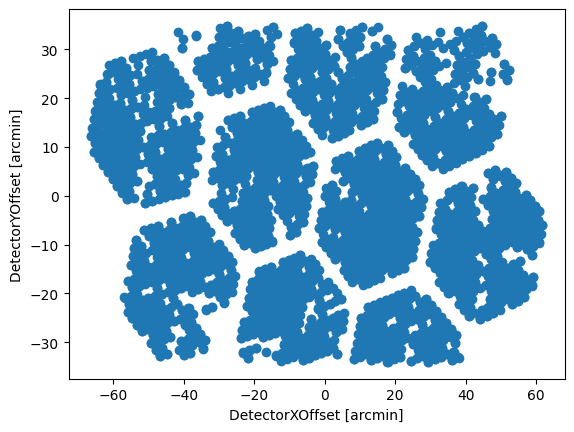

In [65]:
# your code and plots go here
assert set(xoff.keys()) == set(yoff.keys())
x_arcmins = []
y_arcmins = []
for key in xoff.keys():
    x_arcmins.append(xoff[key] / U.arcmin)
    y_arcmins.append(yoff[key] / U.arcmin)
plt.scatter(x_arcmins, y_arcmins)
plt.xlabel("DetectorXOffset [arcmin]")
plt.ylabel("DetectorYOffset [arcmin]");
plt.show()

Another entry in our calibration frame is called `DetectorCalibrationUnits`, which defines the *family* of units in which detector timestreams end up when the appropriate calibration constants are applied.  The `core.G3TimestreamUnits` enum object contains the various families of units that are available.  What units family are the calibration constants stored in? Which of the G3Units attributes would you use for converting these data to physical values?

In [59]:
# print the mapping from an integer value to a units family name
print(core.G3TimestreamUnits.values)
cal_units = core.G3TimestreamUnits.values[calframe["DetectorCalibrationUnits"]]
print(cal_units)

{0: spt3g._libcore.G3TimestreamUnits.None, 1: spt3g._libcore.G3TimestreamUnits.Counts, 2: spt3g._libcore.G3TimestreamUnits.Current, 3: spt3g._libcore.G3TimestreamUnits.Power, 5: spt3g._libcore.G3TimestreamUnits.Resistance, 4: spt3g._libcore.G3TimestreamUnits.Tcmb, 6: spt3g._libcore.G3TimestreamUnits.Angle, 7: spt3g._libcore.G3TimestreamUnits.Distance, 8: spt3g._libcore.G3TimestreamUnits.Voltage, 9: spt3g._libcore.G3TimestreamUnits.Pressure, 10: spt3g._libcore.G3TimestreamUnits.FluxDensity}
Tcmb


## Modules and Pipelines

A common way of manipulating SPT data is to write `modules`, which are functions or classes that take a `G3Frame` as an argument and manipulate it.  We can combine multiple modules together into a `pipeline` to analyze a stream of frames in sequence.  For more details on how this works, see the [documentation](https://cmb-s4.github.io/spt3g_software/modules.html).

For example, here is a simple pipeline module that reads our timestream data and prints it out:

In [60]:
# create a pipeline
pipe = core.G3Pipeline()

# add modules (processing steps) to the pipeline
pipe.Add(core.G3Reader, filename="spt3g_tutorial_data/timestreams.g3")
pipe.Add(core.Dump)

# run it!
pipe.Run()

Frame (Observation) [
"ObservationID" (spt3g._libcore.G3Int) => 235982247
"ObservationStart" (spt3g._libcore.G3Time) => 24-Jun-2024:06:37:27.000000000
"ObservationStop" (spt3g._libcore.G3Time) => 24-Jun-2024:06:42:57.000000000
"SourceName" (spt3g._libcore.G3String) => "RCW38"
]
Frame (PipelineInfo) [
"18-Mar-2025:20:09:00.473370000" (spt3g._libcore.G3PipelineInfo) => UNKNOWN VCS branch, no local diffs
]
Frame (Scan) [
"BoresightDec" (spt3g._libcore.G3Timestream) => 782 samples at 152.6 Hz
"BoresightRa" (spt3g._libcore.G3Timestream) => 782 samples at 152.6 Hz
"RawTimestreams" (spt3g._libcore.G3TimestreamMap) => Timestreams from 1611 detectors
"Turnaround" (spt3g._libcore.G3Bool) => True
]
Frame (Scan) [
"BoresightDec" (spt3g._libcore.G3Timestream) => 1110 samples at 152.6 Hz
"BoresightRa" (spt3g._libcore.G3Timestream) => 1110 samples at 152.6 Hz
"RawTimestreams" (spt3g._libcore.G3TimestreamMap) => Timestreams from 1369 detectors
]
Frame (Scan) [
"BoresightDec" (spt3g._libcore.G3Timestre

You'll notice that the input data file contains many `Scan` frames, which themselves contain telescope boresight pointing timestreams, as well as the raw detector timestreams, all sampled at the same data rate.  The SPT scans the sky in azimuth, stepping in elevation between back-and-forth sweeps.  The telescope coordinates have been converted to Equatorial sky coordinates.  Let's see if we can plot up the scan pattern.  We can define a function that only works on scan frames, and insert it into our pipeline:

In [61]:
def PlotRaDec(frame):
    # skip any frame that doesn't contain the right key
    if "BoresightRa" not in frame:
        return

    # plot coordinates in real units
    plt.plot(frame["BoresightRa"] / core.G3Units.deg, frame["BoresightDec"] / core.G3Units.deg)

Text(0, 0.5, 'Declination [deg]')

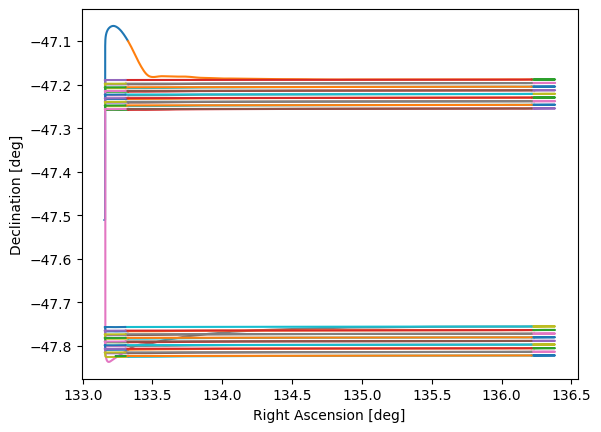

You'll notice that the timestreams are split into sections of constant declination, and sections where the telescope is turning around and/or stepping in declination.  We can add a module to exclude these so-called "turnaround" frames, so that we are only keeping the data where the telescope is moving smoothly in one direction:

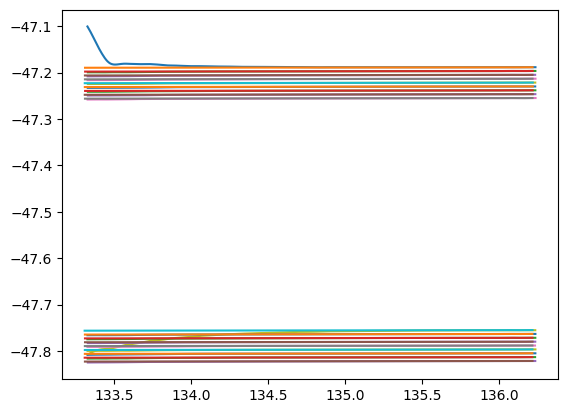

In [66]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename="spt3g_tutorial_data/timestreams.g3")
pipe.Add(lambda fr: fr.get("Turnaround", False) == False)
pipe.Add(PlotRaDec)
pipe.Run()

We can also manipulate the data in the frames.  Once the frames are updated, the next module in the pipeline will receive the frame with the updated data, since this manipulation is effectively happening "in-place".  Let's define a function to apply the calibration constants we loaded above to the input `RawTimestreams`.  This will convert the raw detector timestreams from ADC units to units of CMB temperature.  Note that the modified timestreams are stored to a new key in the frame, because the existing key cannot be overwritten.

In [67]:
def Calibrate(frame):
    # skip frames that don't contain the input key
    if "RawTimestreams" not in frame:
        return

    # get the input timestream data
    ts_in = frame["RawTimestreams"]
    
    # create a new output timestream object
    ts_out = core.G3TimestreamMap()

    # loop over timestreams and multiply by the calibration constant for each detector
    for det, ts in ts_in.items():
        ts2 = ts.astype(float) * cal[det]
        ts2.units = cal_units  # update units
        ts_out[det] = ts2

    # store the calibrated timestreams to the output key in the frame
    frame["CalTimestreams"] = ts_out

An alternative way of manipulating a G3TimestreamMap object is to treat it as a 2D array of shape `(num_dets, num_samples)`.  This may be more efficient when you're doing more complicated operations that can be vectorized.  Both of these `Calibrate` modules result in the same output:

In [68]:
def Calibrate(frame):
    # skip frames that don't contain the input key
    if "RawTimestreams" not in frame:
        return

    # get the input timestream data
    ts_in = frame["RawTimestreams"]

    # convert to 2D numpy array of shape (ndet, nsamp)
    tsarr = np.array(ts_in)  # copy

    # list of detectors
    dets = ts_in.keys()
    
    # calibration array for all detectors present in ts_in
    calarr = np.asarray([cal[det] for det in dets])
    
    # in-place math with broadcasting
    tsarr *= calarr[:, None]

    # create output object with correct timestamps and units
    ts_out = core.G3TimestreamMap(dets, tsarr, ts_in.start, ts_in.stop, cal_units)

    # store the calibrated timestreams to the output key in the frame
    frame["CalTimestreams"] = ts_out

## Making a sky map

Let's take the data for a single detector and create a sky map from it.  First, we need to define the pixel grid onto which the timestream data will be binned.  To make the math relatively easy, let's stick with Cartesian coordinates for the time being:

In [69]:
# center of the sky map
ra0 = 8.0 * U.rahour + 59.0 * U.raminute + 4.8 * U.rasecond
dec0 = -(47.0 * U.degrees + 30.0 * U.arcmin + 36.0 * U.arcsec)

# map dimensions
xlen = 0.5 * U.deg
ylen = 0.5 * U.deg

# pixel resolution
res = 0.5 * U.arcmin

# number of bins along each axis
nx = int(xlen / res)
ny = int(ylen / res)

# bin edges
ra_edges = np.linspace(-xlen / 2, xlen / 2, nx + 1) + ra0
dec_edges = np.linspace(-ylen / 2, ylen / 2, ny + 1) + dec0

And now we need to define a module for binning the timestream data into this sky map.  We're going to iteratively update the sky map with each input frame that we read from file, so the binner cannot be a simple function.  We define a class, in which we store all of the input arguments and the output data arrays as attributes of the class.  Its `__call__` method is then used in the pipeline to update the data arrays.

Notice that we are including pointing offsets for each detector.  The pointing offsets are defined relative to the telescope boresight (i.e. the effective center of the focal plane), so must be converted to sky offsets to be applied correctly.

In [70]:
class SingleMapBinner:
    def __init__(self, det, timestreams="CalTimestreams"):
        self.det = det
        self.timestreams = timestreams

        # array for storing the binned timestream data
        self.data = np.zeros((ny, nx), dtype=float)

        # array for storing the number of times each pixel is "hit" in the timestreams
        self.hits = np.zeros((ny, nx), dtype=float)
    
    def __call__(self, frame):
        if self.timestreams not in frame:
            return

        if self.det not in frame[self.timestreams]:
            return

        ts = frame[self.timestreams][self.det]

        # calculate offset pointing
        dy = yoff[self.det]
        y = np.asarray(frame["BoresightDec"]) - dy
        dx = xoff[self.det] / np.cos(y / U.rad)
        x = np.asarray(frame["BoresightRa"]) + dx

        # update data and hits, in-place
        self.data += np.histogram2d(y, x, bins=[dec_edges, ra_edges], weights=ts)[0]
        self.hits += np.histogram2d(y, x, bins=[dec_edges, ra_edges])[0]

To use this module object, we first instantiate it, then add the instance to the pipeline.  This allows access to the updated `data` and `hits` attributes when the pipeline is finished running.

/tmp/ipykernel_19524/99373056.py:14: RuntimeWarning: invalid value encountered in divide
  m = binner.data / binner.hits / U.mK


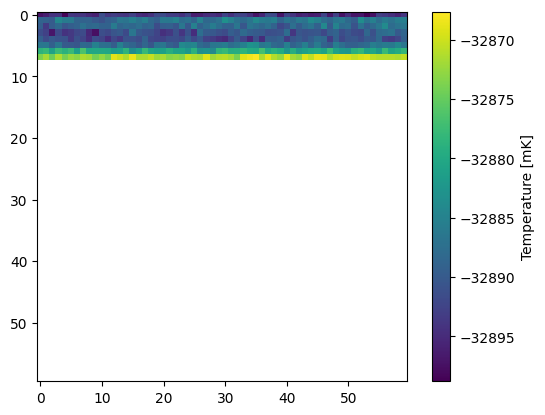

In [73]:
# instantiate binner
binner = SingleMapBinner(det="2019.00e")

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename="spt3g_tutorial_data/timestreams.g3")
pipe.Add(lambda fr: fr.get("Turnaround", False) == False)
pipe.Add(Calibrate)
pipe.Add(binner)

# run the pipeline with some simple time/memory useage profiling
pipe.Run(profile=True)

m = binner.data / binner.hits / U.mK
plt.imshow(m)
plt.colorbar(label="Temperature [mK]");

Notice that this map is not very well populated.  It seems that our one detector is barely in view of the field we're looking at.

#### <span style="color:red">EXERCISE:</span>
Modify the map binner above to loop over all detectors.  Call it `MapBinner`, and run a new pipeline to plot up the resulting total sky map.

In [79]:
# your code and plots go here
class MapBinner:
    def __init__(self, timestreams="CalTimestreams"):
        self.timestreams = timestreams

        # array for storing the binned timestream data
        self.data = np.zeros((ny, nx), dtype=float)

        # array for storing the number of times each pixel is "hit" in the timestreams
        self.hits = np.zeros((ny, nx), dtype=float)

    def __call__(self, frame):
        if self.timestreams not in frame:
            return

        for det, ts in frame[self.timestreams]:
            # calculate offset pointing
            dy = yoff[det]
            y = np.asarray(frame["BoresightDec"]) - dy
            dx = xoff[det] / np.cos(y / U.rad)
            x = np.asarray(frame["BoresightRa"]) + dx

            # update data and hits, in-place
            self.data += np.histogram2d(y, x, bins=[dec_edges, ra_edges], weights=ts)[0]
            self.hits += np.histogram2d(y, x, bins=[dec_edges, ra_edges])[0]

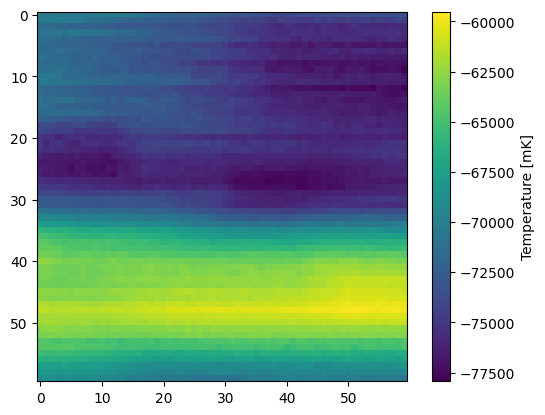

In [80]:
# instantiate binner
binner = MapBinner()

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename="spt3g_tutorial_data/timestreams.g3")
pipe.Add(lambda fr: fr.get("Turnaround", False) == False)
pipe.Add(Calibrate)
pipe.Add(binner)

# run the pipeline with some simple time/memory useage profiling
pipe.Run(profile=True)

m = binner.data / binner.hits / U.mK
plt.imshow(m)
plt.colorbar(label="Temperature [mK]");

### More complex mapmaking

This map binning scheme is quite simple and relatively inefficient.  The [spt3g.maps](https://cmb-s4.github.io/spt3g_software/moddoc_maps.html) package includes definitions of sky map objects that are able to handle different sky projections and pixelization schemes, as well as tools for binning timestreams to sky maps (and vice versa) in an efficient way.

This tutorial also does not touch on detector polarization or polarized mapmaking; for more details on how this works, see, for example [this paper](https://arxiv.org/abs/astro-ph/0606606).

For more detail on the considerations necessary for constructing angular power spectra from CMB maps computed with this filter-and-bin mapmaking scheme, see [this pedagogical paper](https://arxiv.org/pdf/astro-ph/0105302).

## Timestream Processing

We now have a calibrated map, but it has some strange striping and large scale drifts in it, when we would have expected to see some kind of compact blob in the image.  This is because the detector timestreams drift on long timescales due to various forms of contamination: emission from our own atmosphere, thermal drifts in the internal cryogenic environment of the camera, etc.  To remove these drifts, we need to filter the timestreams in such a way as to remove these long timescale drifts.

#### <span style="color:red">EXERCISE:</span>
Create a new pipeline module called `MeanFilter` that subtracts the mean value of each detector timestream for each scan, and stores the resulting timestreams to a new `"FilteredTimestreams"` key in the scan frame.  Write a new pipeline to bin these filtered timestreams into a map, using your multi-detector `MapBinner` you created above.  What does the sky map look like with this coarse filter applied?  Zoom in on the color scale (e.g. by setting the `vmax` argument for `imshow`).  What features do you see in the map?

In [101]:
# your code and plots go here
class MeanFilter:
    def __init__(self, in_key="CalTimestreams", out_key="FilteredTimestreams"):
        self.out_key = out_key
        self.in_key = in_key
    def __call__(self, frame):
        if frame.type != core.G3FrameType.Scan:
            return

        if self.in_key not in frame:
            return

        in_ts_map = frame[self.in_key]
        out_ts_map = core.G3TimestreamMap()

        for key, ts in in_ts_map:
            mean = np.mean(ts)
            out_ts_map[key] = core.G3Timestream(ts - mean)
            out_ts_map[key].units = ts.units
            out_ts_map.start = frame[self.in_key].start
            out_ts_map.stop = frame[self.in_key].stop

        frame[self.out_key] = out_ts_map

In [119]:
# instantiate binner
binner = MapBinner(timestreams="FilteredTimestreams")

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename="spt3g_tutorial_data/timestreams.g3")
pipe.Add(lambda fr: fr.get("Turnaround", False) == False)
pipe.Add(Calibrate)
pipe.Add(MeanFilter)
pipe.Add(binner)

# run the pipeline with some simple time/memory useage profiling
pipe.Run(profile=True)

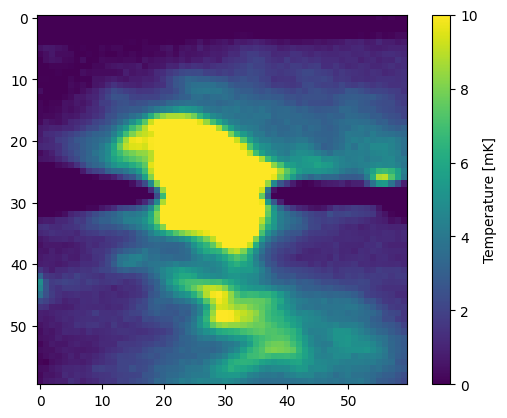

In [122]:
m = binner.data / binner.hits / U.mK
plt.imshow(m, vmin=0, vmax=10)
plt.colorbar(label="Temperature [mK]");

This particular image has a large and bright astrophysical source in the middle.  High-resolution telescopes like ACT and SPT are able to resolve such sources all over the sky.  However, notice that simple filtering without accounting for the existence of the source in the data results in pronounced "wings" along the telescope's scan direction that extend far beyond the width of the source itself.  To reduce the presence of these wings, we can mask out the source prior to applying a filter.

#### <span style="color:red">EXERCISE:</span>

Modify your `MeanFilter` module to compute the timestream mean using only the data samples that fall outside of an 8 arcmin radius around the source.  Call this new module `MaskedMeanFilter`.  Don't forget to account for the individual detector offsets in constructing your mask.

In [136]:
MASK_RADIUS = 8 * U.arcmin

class MaskedMeanFilter:
    def __init__(self, in_key="CalTimestreams", out_key="FilteredTimestreams"):
        self.out_key = out_key
        self.in_key = in_key
    def __call__(self, frame):
        if frame.type != core.G3FrameType.Scan:
            return

        if self.in_key not in frame:
            return

        in_ts_map = frame[self.in_key]
        out_ts_map = core.G3TimestreamMap()

        for det_key, ts in in_ts_map:
            # calculate offset pointing
            dy = yoff[det_key]
            y = np.asarray(frame["BoresightDec"]) - dy
            dx = xoff[det_key] / np.cos(y / U.rad)
            x = np.asarray(frame["BoresightRa"]) + dx
            source_mask = np.sqrt((x - ra0) ** 2 + (y - dec0) ** 2)/U.arcmin > MASK_RADIUS/U.arcmin
            masked_mean = np.mean(ts[source_mask])
            out_ts_map[det_key] = core.G3Timestream(ts - masked_mean)
            out_ts_map[det_key].units = ts.units
            out_ts_map.start = frame[self.in_key].start
            out_ts_map.stop = frame[self.in_key].stop

        frame[self.out_key] = out_ts_map

In [137]:
# instantiate binner
binner = MapBinner(timestreams="FilteredTimestreams")

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename="spt3g_tutorial_data/timestreams.g3")
pipe.Add(lambda fr: fr.get("Turnaround", False) == False)
pipe.Add(Calibrate)
pipe.Add(MaskedMeanFilter)
pipe.Add(binner)

# run the pipeline with some simple time/memory useage profiling
pipe.Run(profile=True)

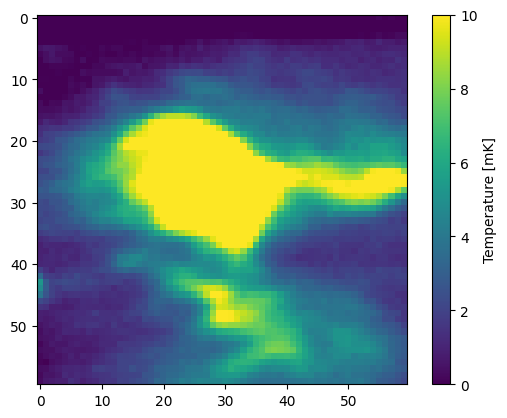

In [140]:
m = binner.data / binner.hits / U.mK
plt.imshow(m, vmin=0, vmax=10)
plt.colorbar(label="Temperature [mK]");

Detector data can be filtered and processed in many more complicated ways.  For example, we could subtract a higher-order polynomial to filter out some smaller scale modes from the data.  We could also use a Fourier filter to do more complex filtering, such as notching out particular lines or limiting the frequency bandwidth of the timestreams.  A complete low-level analysis pipeline incorporates a variety of filters and data cuts in order to reconstruct the underlying sky with high signal-to-noise.

In [25]:
# first_frame = next(core.G3File('spt3g_tutorial_data/timestreams.g3'))
print(core.G3Time.__dict__.keys())
print(core.G3Time.time.__doc__)

dict_keys(['__module__', '__doc__', '__reduce__', '__instance_size__', '__init__', '__safe_for_unpickling__', '__getstate__', '__setstate__', 'GetFileFormatString', 'isoformat', 'Now', 'time', 'mjd', '__eq__', '__ne__', '__lt__', '__le__', '__gt__', '__ge__', '__add__', '__sub__', '__float__', '__int__'])
Time relative to the UNIX epoch


In [29]:
# create a pipeline
pipe = core.G3Pipeline()

class Timer:
    def __init__(self):
        self.seconds = 0
        self.timed_objects = ["BoresightRa", "BoresightRa"]
    def __call__(self, frame):
        if frame.type != core.G3FrameType.Scan:
            return
        self.seconds += (frame["BoresightRa"].stop.time - frame["BoresightRa"].start.time) / U.second

myTimer = Timer()

# add modules (processing steps) to the pipeline
pipe.Add(core.G3Reader, filename="spt3g_tutorial_data/timestreams.g3")
pipe.Add(core.Dump)
pipe.Add(myTimer)

# run it!
pipe.Run()

print(myTimer.seconds)

Frame (Observation) [
"ObservationID" (spt3g._libcore.G3Int) => 235982247
"ObservationStart" (spt3g._libcore.G3Time) => 24-Jun-2024:06:37:27.000000000
"ObservationStop" (spt3g._libcore.G3Time) => 24-Jun-2024:06:42:57.000000000
"SourceName" (spt3g._libcore.G3String) => "RCW38"
]
Frame (PipelineInfo) [
"22-Mar-2025:00:57:19.494245000" (spt3g._libcore.G3PipelineInfo) => UNKNOWN VCS branch, no local diffs
]
Frame (Scan) [
"BoresightDec" (spt3g._libcore.G3Timestream) => 782 samples at 152.6 Hz
"BoresightRa" (spt3g._libcore.G3Timestream) => 782 samples at 152.6 Hz
"RawTimestreams" (spt3g._libcore.G3TimestreamMap) => Timestreams from 1611 detectors
"Turnaround" (spt3g._libcore.G3Bool) => True
]
Frame (Scan) [
"BoresightDec" (spt3g._libcore.G3Timestream) => 1110 samples at 152.6 Hz
"BoresightRa" (spt3g._libcore.G3Timestream) => 1110 samples at 152.6 Hz
"RawTimestreams" (spt3g._libcore.G3TimestreamMap) => Timestreams from 1369 detectors
]
Frame (Scan) [
"BoresightDec" (spt3g._libcore.G3Timestre